### AnimeGANv2


In [ ]:
import torch
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
model = torch.hub.load("bryandlee/animegan2-pytorch", "generator").eval()

Using cache found in /root/.cache/torch/hub/bryandlee_animegan2-pytorch_main


In [ ]:
# Open the image
img = Image.open("face.jpg").convert("RGB")
# Getting pytorch tensor of our image
img_tensor = transforms.ToTensor()(img).unsqueeze(0)

torch.Size([1, 3, 575, 1024])


In [ ]:
out_tensor = model(img_tensor)

In [ ]:
out_tensor_reshaped = out_tensor.detach().numpy().squeeze(0)
final_array = np.transpose(out_tensor_reshaped, (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


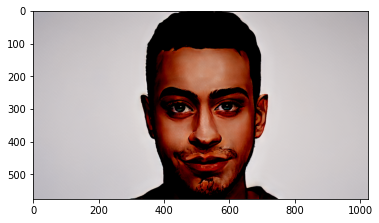

In [ ]:
plt.imshow(final_array)

## CLIP

### Zero Shot

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
device = "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

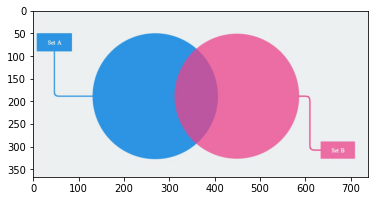

In [ ]:
plt.imshow(Image.open("diagram.jpg"))

In [ ]:
labels = ["pie chart", "a venn diagram", "a blue circle"]

# Preprocessing for images = text
image = preprocess(Image.open("diagram.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(labels).to(device)

with torch.no_grad():    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [ ]:
for label, prob in zip(labels, probs.tolist()[0]):
  print(f"{label}: {prob}")

pie chart: 0.008271127007901669
a venn diagram: 0.888704776763916
a blue circle: 0.10302408039569855


### Similarity

#####text to image similarity search 

In [ ]:
!wget https://dl.dropboxusercontent.com/s/kgjmh6twqgbvkt3/imgs.zip?dl=0 -O imgs.zip

--2022-03-21 06:40:42--  https://dl.dropboxusercontent.com/s/kgjmh6twqgbvkt3/imgs.zip?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28084 (27K) [application/zip]
Saving to: ‘imgs.zip’

imgs.zip            100%[===================>]  27.43K  --.-KB/s    in 0.02s   

2022-03-21 06:40:42 (1.19 MB/s) - ‘imgs.zip’ saved [28084/28084]



In [ ]:
!unzip imgs.zip

Archive:  imgs.zip
replace imgs/11824.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


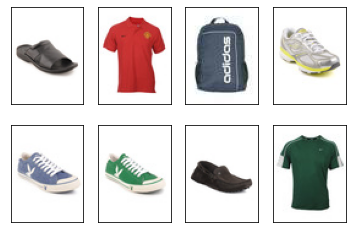

In [ ]:
original_images = []
preprocessed_images = []

for file in os.listdir("/content/imgs"):
  image = Image.open("/content/imgs/"+file).convert("RGB")
  #add original image to list for display and querying in later steps 
  original_images.append(image)
  #preprocess image using preprocess function form clip
  preprocessed_images.append(preprocess(image))
  #display all images for viewing 
  plt.subplot(2, 4, len(original_images))
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

In [ ]:
#text that we want to use to search a similar image 
query = "this is a green sneaker"

In [ ]:
#format the images and text query into proper formats for the model 
image_input = torch.tensor(np.stack(preprocessed_images))
text_tokens = clip.tokenize(query)

In [ ]:
#pass images and text query into model to generate embeddings 
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [ ]:
#calculate cosine similarity between text query and image embeddings 
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
similarity

array([[0.18796408, 0.14906888, 0.17230564, 0.21923542, 0.23357531,
        0.31467077, 0.22065231, 0.24171546]], dtype=float32)

In [ ]:
# Get the index of the most similar image using argmax which gets the index of the highest value in a array 
index_most_similar_image = similarity.argmax()
# Index the list containing the original images to get the most similar image for displaying 
most_similar_image = original_images[index_most_similar_image]

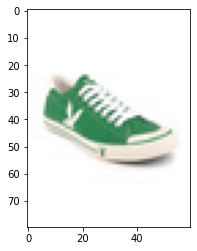

In [ ]:
#display most similar image 
plt.imshow(most_similar_image)

#####image to image similarity search 

Here, our image will be the query. The other images will be the input

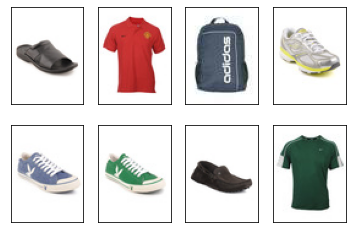

In [ ]:
#repeat the same steps as previous example by loading and preprocessing images  
original_images = []
preprocessed_images = []
for file in os.listdir("/content/imgs"):
  image = Image.open("/content/imgs/"+file).convert("RGB")
  #add original image to list for display and querying in later steps 
  original_images.append(image)
  #preprocess image using preprocess function form clip
  preprocessed_images.append(preprocess(image))

  #display all images for viewing 
  plt.subplot(2, 4, len(original_images))
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

In [ ]:
query_img_index = 2

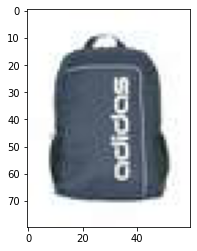

In [ ]:
plt.imshow(original_images[query_img_index])

In [ ]:
#remove the image you want to query from both list (both list need to maintain the same index )
original_images.pop(query_img_index)
#use pop to remove the image and save it to a variable for querying 
query = preprocessed_images.pop(query_img_index)

#format the images and text query into proper formats for the model 
image_input = torch.tensor(np.stack(preprocessed_images))
image_query =  torch.tensor(np.expand_dims(query, axis=0))

In [ ]:
#pass images and text query into model to generate embeddings 
with torch.no_grad():
    image_features_1 = model.encode_image(image_input).float()
    image_features_2 = model.encode_image(image_query).float()

In [ ]:
#calculate cosine simialrity between text query and image embeddings 
image_features_1 /= image_features_1.norm(dim=-1, keepdim=True)
image_features_2 /= image_features_2.norm(dim=-1, keepdim=True)
similarity = image_features_2.cpu().numpy() @ image_features_1.cpu().numpy().T

In [ ]:
#get the index of thew most similar image using argmax which gets the index of the highest value in a array 
index_most_similar_image = similarity.argmax()
#index the list containing the original images to get the most similar image for displaying 
most_similar_image = original_images[index_most_similar_image]

In [ ]:
similarity

array([[0.7069161 , 0.637212  , 0.6855819 , 0.6386665 , 0.6701352 ,
        0.7200856 , 0.73104835]], dtype=float32)

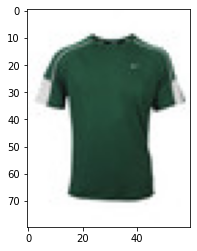

In [ ]:
#display most similar image 
plt.imshow(most_similar_image)